# Практическое задание 2

**Построение графа друзей из VK**

1. Создадим класс пользователя ВК (вершины графа). Пользователь задается двумя параметрами:

- VK ID
- Имя (только для друзей уровня 0, т.к. остальных хранить экономически невыгодно)
- Список друзей (их VK ID)

In [51]:
import json

class vk_user:
    def __init__(self, vk_id, name, friends):
        self.vk_id = vk_id
        self.name = name
        self.friends = friends

    def to_dict(self):
        return {
            'vk_id': self.vk_id,
            'name': self.name,
            'friends': self.friends
        }

    @staticmethod
    def from_dict(data):
        return vk_user(vk_id=data['vk_id'], name=data['name'], friends=data['friends'])
    

def save_people_to_json_file(usrs, filename):
    with open(filename, 'w') as file:
        json.dump([u.to_dict() for u in usrs], file)


def load_people_from_json_file(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
        return [vk_user.from_dict(p) for p in data]

Создадим список "корневых" пользователей (то есть друзей глубины 0):

In [43]:
import pandas as pd

users = []

df = pd.read_csv("students.csv")
df.columns = ["full_name", "link", "id"]
df = df.dropna()
df['id'] = df['id'].astype(int).astype(str)
df.head(10)

for index, row in df.iterrows():
    users.append(vk_user(row["id"], row["full_name"], None))

По данному списку пройдемся дважды: в первый раз будут определены друзья для корневых пользователей, во второй раз - друзья их друзей.

В нем учтены два ограничения:
- Для каждого пользователя число друзей ограничено сотней
- Для друзей второго уровня учитываются только пользователи, найденные на первом этапе

In [44]:
import requests

deep = 2
MAX_FRIENDS_COUNT = 100
for d in range(deep):
    new_users = []
    for user in users:
        print(f"User with id = {user.vk_id} > ", end="")
        if user.friends == None:
            print("Fetching... > ", end="")
            url = f'https://api.vk.com/method/friends.get?user_id={user.vk_id}&v=5.199'
            response = requests.get(url)
            if 'response' not in response.json():
                print("Profile is private", end="\n")
                continue
            friends = response.json()['response']['items']
            found = 0
            added = 0
            for f in range(len(friends)):
                friend = friends[f]
                if f >= MAX_FRIENDS_COUNT:
                    break
                if d != 1 or any(person.vk_id == friend for person in users):
                    if user.friends == None:
                        user.friends = []
                    user.friends.append(friend)
                    found += 1
                    if all(person.vk_id != friend for person in users):
                        new_users.append(vk_user(friend, None, None))
                        added += 1
            print(f"Found {found}, added {added} friends of {100 if len(friends) > 100 else len(friends)}", end="\n")
        else:
            print("Already processed", end="\n")
    users.extend(new_users)


User with id = 172350665 > Fetching... > Found 100, added 100 friends of 100
User with id = 229180632 > Fetching... > Found 49, added 49 friends of 49
User with id = 145195585 > Fetching... > Found 100, added 100 friends of 100
User with id = 193887357 > Fetching... > Found 100, added 100 friends of 100
User with id = 386272361 > Fetching... > Found 76, added 76 friends of 76
User with id = 204720239 > Fetching... > Found 100, added 100 friends of 100
User with id = 162225997 > Fetching... > Found 87, added 87 friends of 87
User with id = 860446539 > Fetching... > Found 10, added 10 friends of 10
User with id = 472133870 > Fetching... > Found 100, added 100 friends of 100
User with id = 195614586 > Fetching... > Found 100, added 100 friends of 100
User with id = 825545292 > Fetching... > Found 18, added 18 friends of 18
User with id = 750743366 > Fetching... > Found 19, added 19 friends of 19
User with id = 637593527 > Fetching... > Profile is private
User with id = 299106540 > Fetchin

Поскольку накладно каждый раз обращаться к VK API, данные будут выгружены один раз и скомпанованы в JSON-файл.

In [59]:
save_people_to_json_file(users, "friendships.json")

In [58]:
users = load_people_from_json_file('friendships.json')

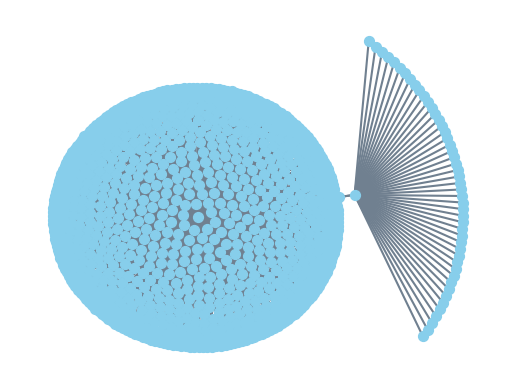

In [23]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.layout import kamada_kawai_layout


# Создание графа
G = nx.Graph()

# Добавление узлов и рёбер в граф
top_now = True
counter = 1000
for line in cleared_users:
    if top_now:
        top_now = False
        continue
    parts = line.strip().split(',')
    if len(parts) == 2:
        G.add_edge(parts[0], parts[1])
    counter -= 1
    if counter < 0:
        break

# Рисуем граф
node_size = 50  # Размер кружка
node_color = 'skyblue'  # Цвет узлов

# Настройка цветов рёбер
edge_color = 'slategray'  # Цвет рёбер
width = 1.5  # Толщина рёбер

pos = kamada_kawai_layout(G)

# Рисуем граф
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color)
nx.draw_networkx_edges(G, pos, edge_color=edge_color, width=width)
plt.axis('off')
plt.show()

# определяем список рёбер
# список кортежей, каждый из которых представляет ребро
# кортеж (id_1, id_2) означает, что узлы id_1 и id_2 соединены ребром
# edges = [(1, 2), (1, 3), (2, 3), (2, 4), (3, 5), (5, 5)]

# # добавляем информацию в объект графа
# G.add_nodes_from(nodes)
# G.add_edges_from(edges)

# # рисуем граф и отображаем его
# nx.draw(G, with_labels=True, font_weight='bold')
# plt.show()